# ANALYZING & FORECASTING GROSS DOMESTIC PRODUCT (GDP) TRENDS 

# (Case Study - Kenya)

## Introduction

Kenyan Parliament recently, on the 26th June 2023, passed to law the contentious Finance Bill 2023 proposing a raft of tax policy measures which aim to yield additional revenue and explore more effective measures to enhance Country's revenue collection.

The House argued that, in comparison to other comparable African countries’ Tax revenue as a percentage of Gross Domestic Product (GDP) like Botswana’s 24 percent, Mauritius’ 18 percent and Zambia’s 17 percent, Kenya was falling behind in terms of tax revenue collection at 13 percent as at 2021. The mentioned countries have since managed to achieve higher tax revenue collection rates thus highlighting the need to reassess Country's tax policies and explore more effective measures to enhance revenue collection.

The Government feels the ratio of tax revenue as a percentage of Gross Domestic Product (GDP) being well below acceptable levels to enable spur economic growth & reduce cost of living in the long term. **`(According to the World Bank, tax revenues above 15% of a country’s GDP are a key ingredient for economic growth and, ultimately, poverty reduction)`**

Some of the questions a taxpayer might ask based on the proposed bill might include:

> **Is GDP level growing proportionately to the projected tax revenue collections to enable government meet its target?**

Hence GDP becomes a critical factor to explore, predict and assist determine if the country is in line to achieve its bold aspirations within the next 3-4 years.

## Business Understanding

The tax-to-GDP ratio is a measure of a nation's tax revenue relative to the size of its economy. GDP is a vital economic indicator that reflects the overall economic performance of countries and guides policy-making, investment decisions, and strategic planning.

>***Project shall aim to analyse Country's historical GDP trends and forecast future GDP growth. The analysis shall assist provide insights into economic growth patterns, identify emerging trends, and support evidence-based decision-making for various stakeholders.***

## Data Understanding & Preparation

Data downloaded from The World Bank website database (https://datatopics.worldbank.org/world-development-indicators) and saved remotely for preprocessing. Our target variable (GDP) & other features/indicators columns collected over a period of time explained as below: Daily data aggregated (Weighted average aggregation method); annualized & expressed in U.S. Dollars for each period unless stated otherwise.

- **Year**: Annual periodicity (62 year trend analysis obtained between 1960 & 2022)
- **GDP**: Gross Domestic Product
- **Exports**: Total transactions value in goods and services from residents to non-residents
- **Imports**: Total transactions value in goods and services from non-residents to residents.
- **ExchRate**: Exchange Rate - Local currency per U.S. Dollar period average expressed in National Currency Unit
- **InfRte**: Inflation Rate
- **Population**: Total Population of a country
- **TaxRev**: Total tax revenue collected.
- **LbrFrce**: Labor Force
- **UnEmpRte**: Unemployment Rate
- **EmpRte**: Employment Rate
- **GrossDomSavg**: Gross Domestic Savings
- **GrossConsump**: Gross Consumption/Expenditure
- **IntPen**:Individuals using the Internet (% of population): Internet Penetration Rate
- **AgriOutput**: Agriculture, forestry, and fishing, value added; generally focuses on production or manufacturing processes, marketing or services that increase the value of primary agricultural commodities

Noting that Time Series Analysis Models work on Uni-variate data; and for a deeper mastering of topic at hand; we shall go an extra step to explore all the columns & their relationships, with our predictor/target variable (GDP) & with each other.

In [1]:
#Importing necessary libraries
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
import itertools
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import matplotlib
sns.set(style="ticks", color_codes=True)
#sns.set_style("whitegrid")

Data Loading & changing the year in our dataset from "non-null object" to "non-null datetime" (i.e., change the data type of dates)and setting as index

In [2]:
#Importing & loading dataset
df = pd.read_csv('Timeseries_Data.csv')
#Convert Year to a datetime column
df['Year'] = pd.to_datetime(df['Year'])
# Make Year the index 
df.set_index('Year', inplace=True)
#visualizing top rows of our dataset
df.head(3)

,GDP,TaxRev,Population,Exports,Imports,GrossDomSavg,GrossConsump,AgriOutput,LbrFrce,ExchRate,InfRte,IntPen,UnEmpRte,EmpRte
Year,,,,,,,,,,,,,,
1960-12-31,"6,102,055,383",NaN,"7,751,435","246,049,901","266,419,907","135,645,848",NaN,"279,691,874",NaN,7.14,1.24%,NaN,NaN,NaN
1961-12-31,"5,627,642,856",NaN,"8,047,470","259,433,896","246,847,901","133,041,863",NaN,"270,185,892",NaN,7.14,2.46%,NaN,NaN,NaN
1962-12-31,"6,159,869,229",NaN,"8,363,578","278,123,875","261,519,895","142,939,845",NaN,"326,185,869",NaN,7.14,3.12%,NaN,NaN,NaN


**`ExchRate`** column currency in National Loacal Currency while the other column data expresed in U.S. Dollars. For consistency, we shall create a new calculated column **`ExcRate`** that shall take this into consideration and proceed to drop initial column.

In [3]:
#creating new column
df['ExcRate'] = round ((1 / df['ExchRate']),2)
#dropping `ExchRate` column
df.drop(['ExchRate'], axis=1)
#view top rows
df.head(3)

,GDP,TaxRev,Population,Exports,Imports,GrossDomSavg,GrossConsump,AgriOutput,LbrFrce,ExchRate,InfRte,IntPen,UnEmpRte,EmpRte,ExcRate
Year,,,,,,,,,,,,,,,
1960-12-31,"6,102,055,383",NaN,"7,751,435","246,049,901","266,419,907","135,645,848",NaN,"279,691,874",NaN,7.14,1.24%,NaN,NaN,NaN,0.14
1961-12-31,"5,627,642,856",NaN,"8,047,470","259,433,896","246,847,901","133,041,863",NaN,"270,185,892",NaN,7.14,2.46%,NaN,NaN,NaN,0.14
1962-12-31,"6,159,869,229",NaN,"8,363,578","278,123,875","261,519,895","142,939,845",NaN,"326,185,869",NaN,7.14,3.12%,NaN,NaN,NaN,0.14


Removing special characters in dataset: We shall remove all commas (,) and percentage signs (%) from dataframe & progress to convert data types from object to numeric.

In [4]:
#removing all commas from dataframe
df.replace(',','', regex=True, inplace=True)
#removing all % sign from dataframe
df.replace('%','', regex=True, inplace=True)
#visualizing top rows of our dataset
df.head(3)

,GDP,TaxRev,Population,Exports,Imports,GrossDomSavg,GrossConsump,AgriOutput,LbrFrce,ExchRate,InfRte,IntPen,UnEmpRte,EmpRte,ExcRate
Year,,,,,,,,,,,,,,,
1960-12-31,6102055383,NaN,7751435,246049901,266419907,135645848,NaN,279691874,NaN,7.14,1.24,NaN,NaN,NaN,0.14
1961-12-31,5627642856,NaN,8047470,259433896,246847901,133041863,NaN,270185892,NaN,7.14,2.46,NaN,NaN,NaN,0.14
1962-12-31,6159869229,NaN,8363578,278123875,261519895,142939845,NaN,326185869,NaN,7.14,3.12,NaN,NaN,NaN,0.14


Checking dataframe for any duplicate rows.

In [5]:
#Checking for any duplicated rows
dup_rows = df[df.duplicated()]
print("Number of Duplicates:", df.duplicated().sum())

Number of Duplicates: 0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63 entries, 1960-12-31 to 2022-12-31
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GDP           63 non-null     object 
 1   TaxRev        9 non-null      object 
 2   Population    63 non-null     object 
 3   Exports       63 non-null     object 
 4   Imports       63 non-null     object 
 5   GrossDomSavg  63 non-null     object 
 6   GrossConsump  59 non-null     object 
 7   AgriOutput    63 non-null     object 
 8   LbrFrce       33 non-null     object 
 9   ExchRate      63 non-null     float64
 10  InfRte        63 non-null     object 
 11  IntPen        31 non-null     object 
 12  UnEmpRte      32 non-null     float64
 13  EmpRte        32 non-null     float64
 14  ExcRate       63 non-null     float64
dtypes: float64(4), object(11)
memory usage: 7.9+ KB


Converting object to numeric data types: This shall enable us to check the overall statistics about our dataset

In [7]:
cols = df.columns.drop(['ExchRate','UnEmpRte','EmpRte','ExcRate'])
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [8]:
#checking our new data types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63 entries, 1960-12-31 to 2022-12-31
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GDP           63 non-null     int64  
 1   TaxRev        9 non-null      float64
 2   Population    63 non-null     int64  
 3   Exports       63 non-null     int64  
 4   Imports       63 non-null     int64  
 5   GrossDomSavg  63 non-null     int64  
 6   GrossConsump  59 non-null     float64
 7   AgriOutput    63 non-null     int64  
 8   LbrFrce       33 non-null     float64
 9   ExchRate      63 non-null     float64
 10  InfRte        63 non-null     float64
 11  IntPen        31 non-null     float64
 12  UnEmpRte      32 non-null     float64
 13  EmpRte        32 non-null     float64
 14  ExcRate       63 non-null     float64
dtypes: float64(9), int64(6)
memory usage: 7.9 KB


In [9]:
#checking for unique values in columns
df.nunique()

GDP             63
TaxRev           9
Population      63
Exports         63
Imports         63
GrossDomSavg    63
GrossConsump    59
AgriOutput      63
LbrFrce         33
ExchRate        50
InfRte          62
IntPen          28
UnEmpRte        29
EmpRte          32
ExcRate         13
dtype: int64

> ***Overall summary of our dataset***\
> Dataset contains 63 rows & 15 columns.\
> Also for each of the columns, some of the non-null count are less than 63 which implies that some columns contain null/missing  values.\
> Columns contains continuous data with Nill categorical values

In [10]:
#Getting overall statistics of the dataset
statistics = df.describe()
statistics

,GDP,TaxRev,Population,Exports,Imports,GrossDomSavg,GrossConsump,AgriOutput,LbrFrce,ExchRate,InfRte,IntPen,UnEmpRte,EmpRte,ExcRate
count,6.300000e+01,9.000000e+00,6.300000e+01,6.300000e+01,6.300000e+01,6.300000e+01,5.900000e+01,6.300000e+01,3.300000e+01,63.000000,63.000000,31.000000,32.000000,32.000000,63.000000
mean,3.465737e+10,1.290484e+10,2.636646e+07,3.977859e+09,6.080966e+09,2.720245e+09,2.682398e+10,5.046157e+09,1.568976e+07,44.450952,9.816984,8.507097,3.378750,3.884375,0.063175
std,2.394633e+10,1.882830e+09,1.409749e+07,3.990388e+09,7.120382e+09,3.502180e+09,3.473024e+10,6.338950e+09,4.990411e+06,37.452107,8.075554,9.446365,0.843528,2.791971,0.056649
min,5.627643e+09,1.037307e+10,7.751435e+06,2.460499e+08,2.468479e+08,1.330419e+08,9.570395e+08,2.701859e+08,8.597324e+06,7.000000,-0.170000,0.000000,2.760000,1.450000,0.010000
25%,1.520059e+10,1.123153e+10,1.387709e+07,1.063833e+09,1.169746e+09,5.725502e+08,5.650067e+09,1.070700e+09,1.127230e+07,7.380000,4.850000,0.215000,2.920000,1.675000,0.010000
50%,3.062288e+10,1.322804e+10,2.391824e+07,2.202462e+09,2.446514e+09,1.220072e+09,9.017796e+09,2.133981e+09,1.517137e+07,27.510000,8.640000,4.400000,3.110000,1.870000,0.040000
75%,4.822699e+10,1.438025e+10,3.748102e+07,6.470446e+09,9.274007e+09,2.831545e+09,3.742020e+10,5.939220e+09,1.971833e+07,77.955000,12.635000,16.545000,3.265000,7.500000,0.135000
max,9.479584e+10,1.519757e+10,5.402749e+07,1.385453e+10,2.440153e+10,1.355607e+10,1.222788e+11,2.400616e+10,2.498516e+07,117.870000,45.980000,29.530000,5.640000,8.160000,0.140000


>From above output we can see the columns are not scaled. The mean, minimum and maximum values, and even the standard deviation values for all columns are very different.
>This unscaled dataset is not suitable for processing by most statistical algorithms (`For example, the linear regression algorithm tends to assign larger weights to the features with larger values, which can affect the overall model performance`)

**Standard Scaling**

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [12]:
scaled_df = pd.DataFrame(scaled_data, columns = df.columns)
scaled_df.head()

,GDP,TaxRev,Population,Exports,Imports,GrossDomSavg,GrossConsump,AgriOutput,LbrFrce,ExchRate,InfRte,IntPen,UnEmpRte,EmpRte,ExcRate
0,-1.202050,NaN,-1.331056,-0.942711,-0.823165,-0.743925,NaN,-0.757973,NaN,-1.004233,-1.070623,NaN,NaN,NaN,1.367057
1,-1.222021,NaN,-1.309888,-0.939330,-0.825936,-0.744675,NaN,-0.759484,NaN,-1.004233,-0.918337,NaN,NaN,NaN,1.367057
2,-1.199616,NaN,-1.287285,-0.934609,-0.823859,-0.741826,NaN,-0.750579,NaN,-1.004233,-0.835952,NaN,NaN,NaN,1.367057
3,-1.176854,NaN,-1.263429,-0.929888,-0.822890,-0.740270,NaN,-0.745795,NaN,-1.004233,-1.138029,NaN,NaN,NaN,1.367057
4,-1.162851,NaN,-1.238389,-0.920625,-0.819578,-0.733404,-0.751189,-0.743951,NaN,-1.004233,-1.237889,NaN,NaN,NaN,1.367057


In [13]:
round((scaled_df.describe()),3)

,GDP,TaxRev,Population,Exports,Imports,GrossDomSavg,GrossConsump,AgriOutput,LbrFrce,ExchRate,InfRte,IntPen,UnEmpRte,EmpRte,ExcRate
count,63.000,9.000,63.000,63.000,63.000,63.000,59.000,63.000,33.000,63.000,63.000,31.000,32.000,32.000,63.000
mean,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000
std,1.008,1.061,1.008,1.008,1.008,1.008,1.009,1.008,1.016,1.008,1.008,1.017,1.016,1.016,1.008
min,-1.222,-1.426,-1.331,-0.943,-0.826,-0.745,-0.751,-0.759,-1.443,-1.008,-1.247,-0.915,-0.745,-0.886,-0.946
25%,-0.819,-0.943,-0.893,-0.736,-0.695,-0.618,-0.615,-0.632,-0.899,-0.998,-0.620,-0.892,-0.553,-0.804,-0.946
50%,-0.170,0.182,-0.175,-0.448,-0.515,-0.432,-0.517,-0.463,-0.105,-0.456,-0.147,-0.442,-0.324,-0.733,-0.412
75%,0.571,0.831,0.795,0.630,0.452,0.032,0.308,0.142,0.820,0.902,0.352,0.865,-0.137,1.316,1.278
max,2.532,1.292,1.978,2.495,2.594,3.119,2.772,3.015,1.892,1.976,4.514,2.262,2.724,1.556,1.367


Checking Distribution & Correlation of each of our variables (**Univariate Analysis**)

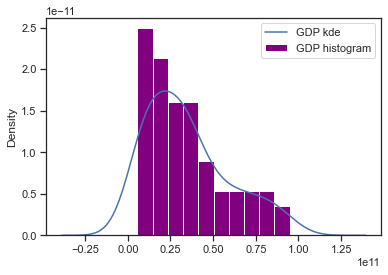

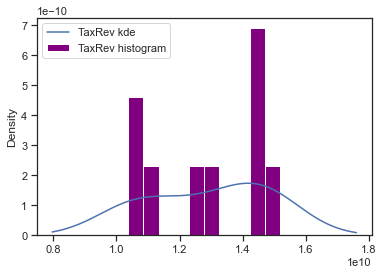

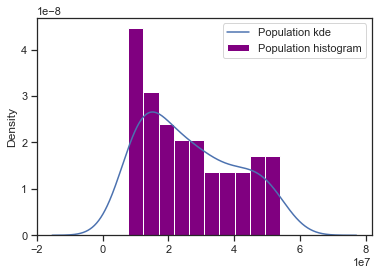

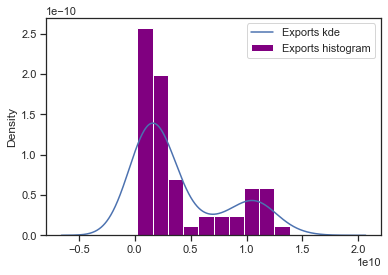

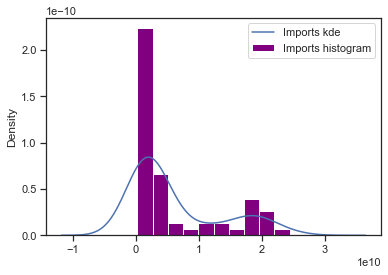

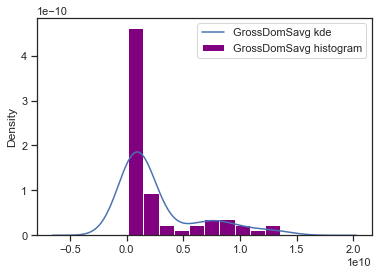

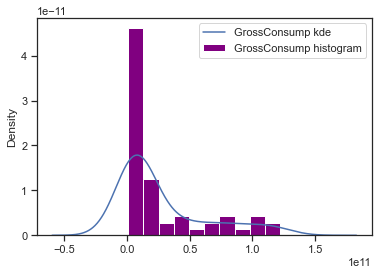

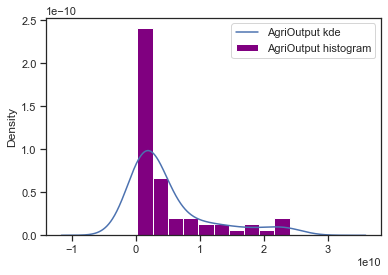

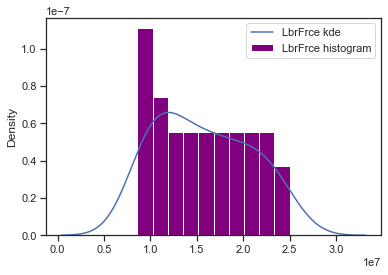

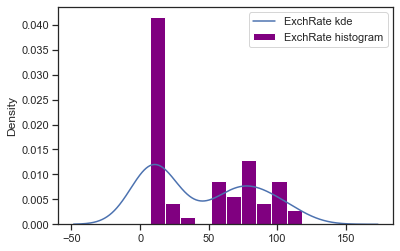

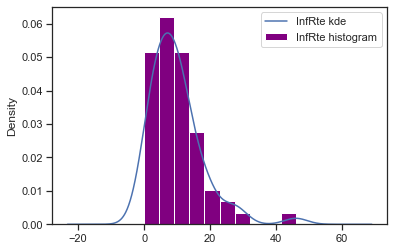

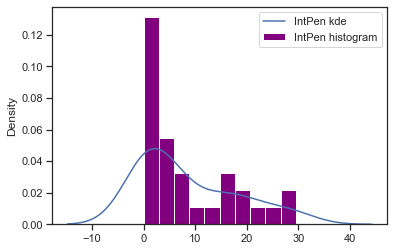

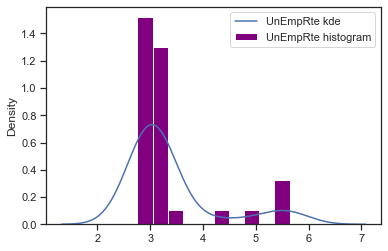

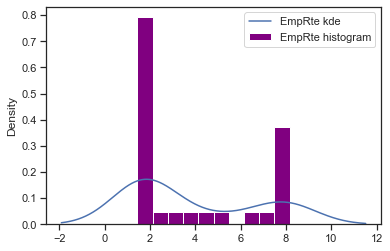

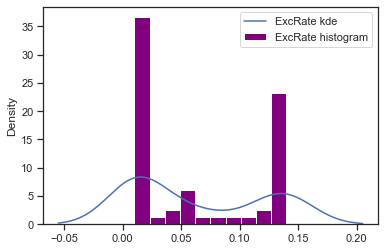

In [14]:
# For all the variables, check distribution by creating a histogram with kde
for column in df:
    df[column].plot.hist(density=True, label = column+' histogram',color='purple')
    df[column].plot.kde(label =column+' kde',color='b')
    plt.legend()
    plt.show()

> **Variables follow a particular distribution - Non perfectly normal.**

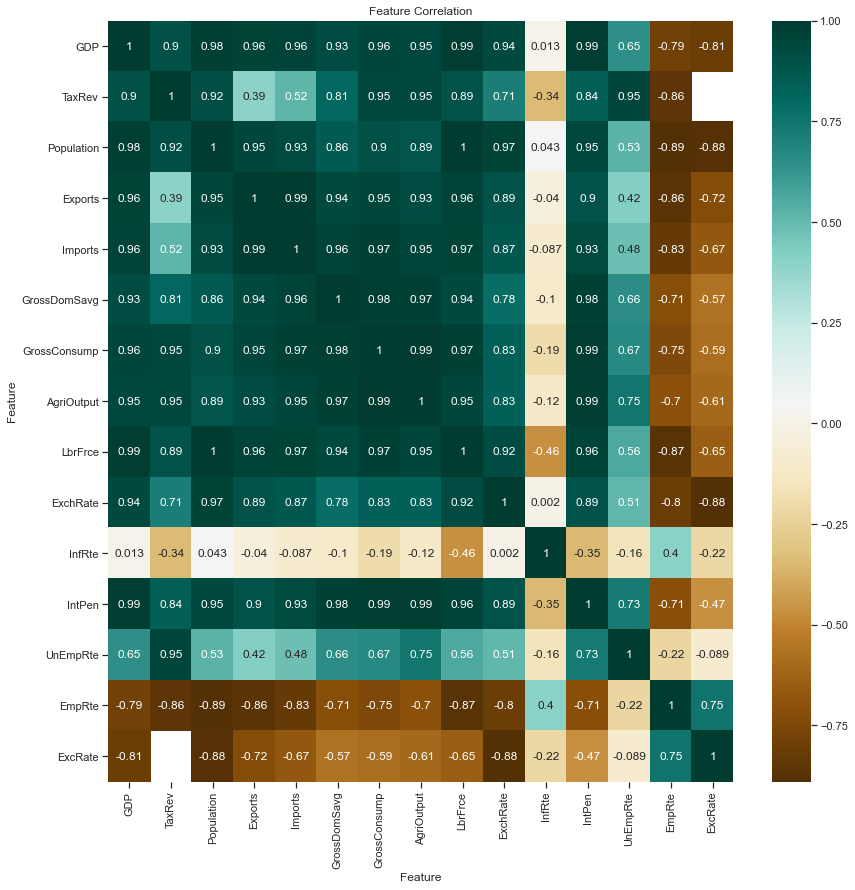

In [15]:
#Correlation heatmap
fig, ax = plt.subplots(figsize=(14,14)) 
sns.heatmap(scaled_df.corr(), annot=True, ax=ax, cmap='BrBG').set(
    title = 'Feature Correlation', xlabel = 'Feature', ylabel = 'Feature')
plt.show()

>**In the plot above, the dark green squares correspond to highly correlated features (>0.75). Darker brown segments corresponds to negatively correlated features (<-0.75).\
>The diagonal represents the correlation of a feature with itself, therefore the value is 1.\
>We can also see that there are a few features that are highly correlated.**

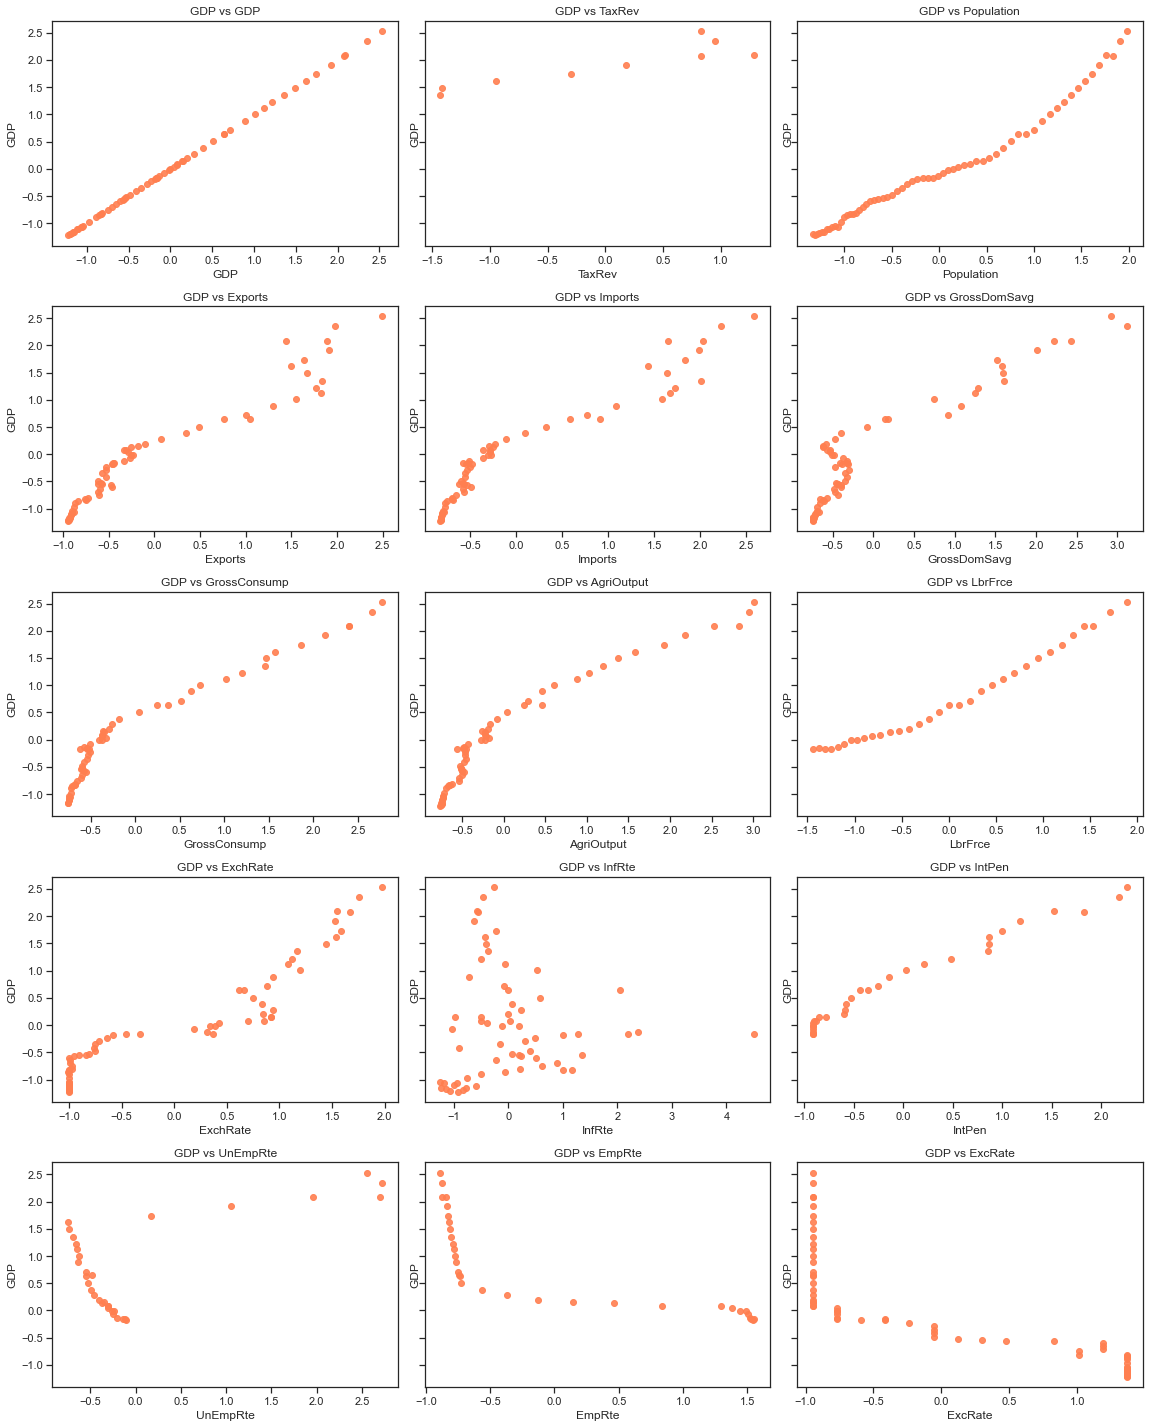

In [16]:
#Plotting subplots to visualize correlation between predictor & target variable
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16,20), sharey=True )
for ax, column in zip(axes.flatten(), scaled_df.columns):
    ax.scatter(scaled_df[column], scaled_df['GDP'], label=column, alpha=.9,color='coral')
    ax.set_title(f'GDP vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('GDP')
fig.tight_layout()

> **GDP increasing over time with strong positive correlation with Population, Gross Consumption, Agriculture Output, Labor Force but a negative correlation noted with country's employment rate and exchange rate. Minimal/No correlation likewise noted with inflation rate**

**Detecting, Dealing & Visualizing Missing Values in our Dataset**

In [17]:
# Printing out the columns with missing values
[col for col in df.columns if df[col].isnull().any()]

['TaxRev', 'GrossConsump', 'LbrFrce', 'IntPen', 'UnEmpRte', 'EmpRte']

In [18]:
#Creating Function Returning Missing Values Table

def missing_values_table(df):
    mis_val = df.isnull().sum() #Total Missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df) #%ge of missing values
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) #creating missing values table
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #Rename columns
    mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1) # Sort table by %ge of missing descending
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.") #Print out Info
    
    return mis_val_table_ren_columns #Return the dataframe with missing information

In [19]:
#Missing Values dataframe
missing_df = missing_values_table(df)
missing_df

Your selected dataframe has 15 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
TaxRev,54,85.7
IntPen,32,50.8
UnEmpRte,31,49.2
EmpRte,31,49.2
LbrFrce,30,47.6
GrossConsump,4,6.3


> **Nil missing values detected on our target variable (GDP)**

<AxesSubplot:>

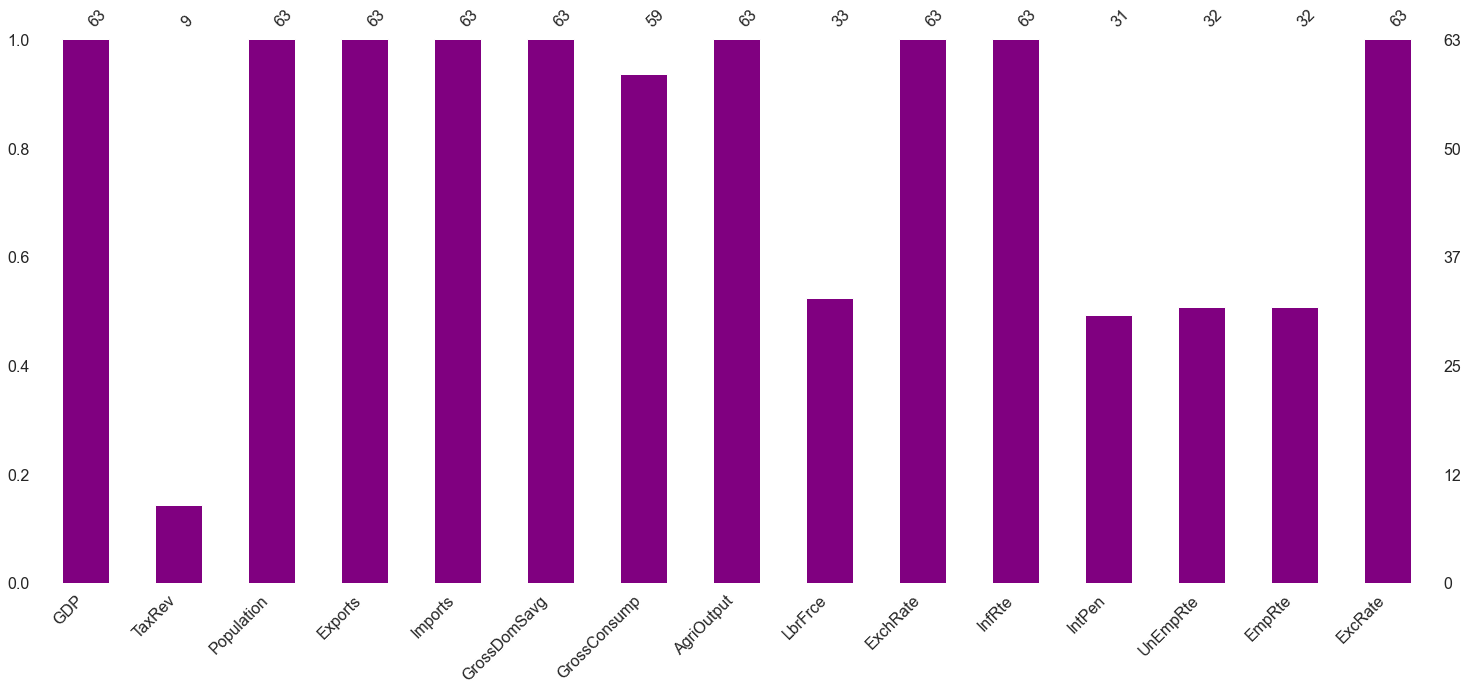

In [20]:
#Visualizing Missing Values using bar plot
msno.bar(df, color = 'purple')

> Here you can immediately see that the `TaxRev`,`UnEmpRte`, `EmpRte`,`IntPen` features have considerable amounts of missing values while `GrossConsump` has few missing values.

<AxesSubplot:>

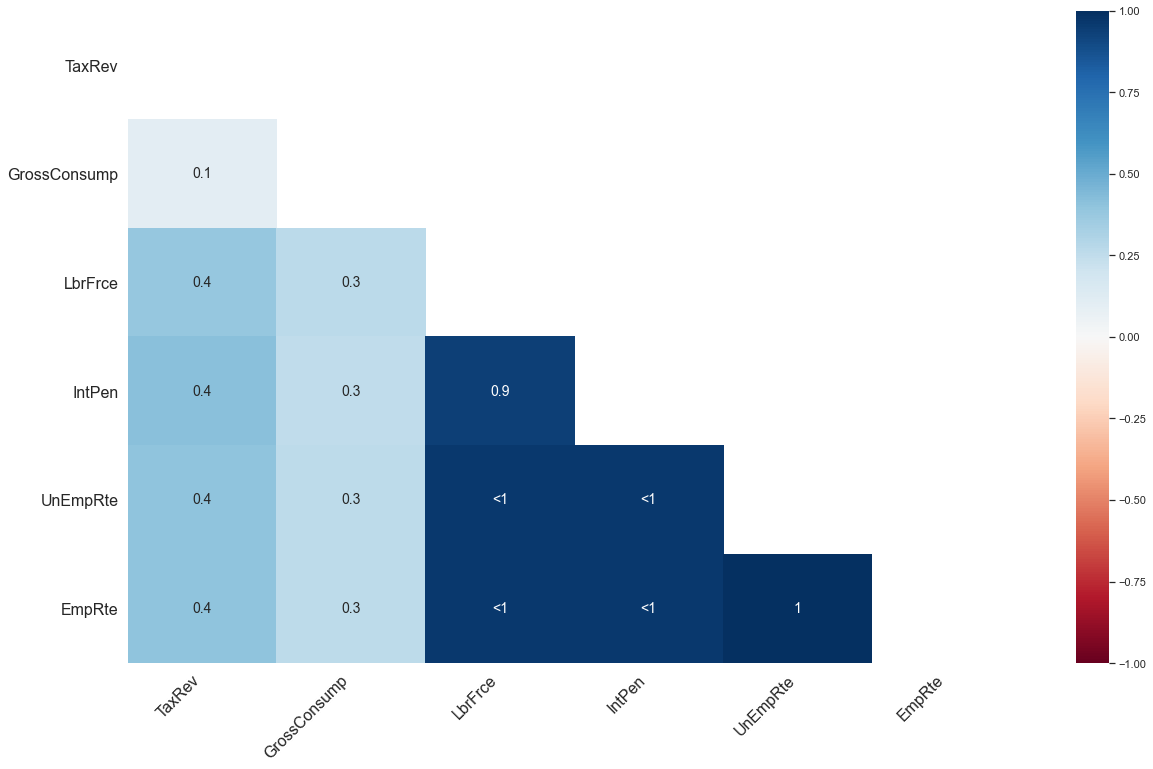

In [21]:
# Gives a heatmap of how missing values are related
msno.heatmap(df)

> **Perfect correlation between `UnEmpRte~EmpRte` & `LbrFrce~IntPen` feature pairs\
> There are no strong correlations between other missing values of different features**

Filling missing values of predictor variables with zero due to data unavailability for past periods and proceeding to perform feature importance. (Most columns missing data dated pre-2013)

In [26]:
df.fillna(value=0, inplace=True)

In [27]:
missing_df_1=missing_values_table(df)

Your selected dataframe has 15 columns.
There are 0 columns that have missing values.


[0.01354839 0.09919355 0.10435484 0.09403226 0.10435484 0.1
 0.10403226 0.04516129 0.07983871 0.10016129 0.03677419 0.04048387
 0.04225806 0.03580645]


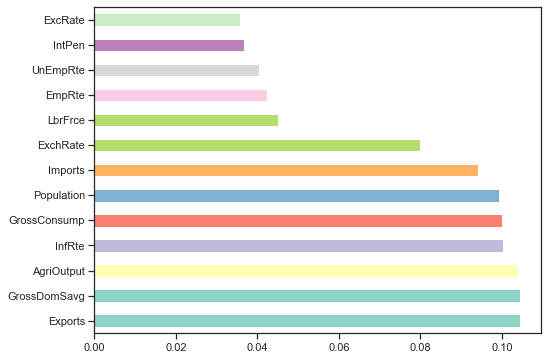

In [28]:
X = df.drop(['GDP'], axis = 1) #predictors
y = df['GDP'] #target variable

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)

#visualizing features importance
pred_colors = plt.cm.Set3(np.linspace(0, 1,  len(df. columns)))
plt.figure(figsize=(8,6))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

#feat_importances.plot(kind='barh') #top ten # not sorted
feat_importances.nlargest(13).plot(kind='barh',color=pred_colors) #top features (all)
plt.show()

> **Least features synonimous with columns with missing data**

**Time Series Analysis**

In [70]:
#Checking trends of predictor varioables & top predictors
trends = df[['GDP','Exports','GrossDomSavg','AgriOutput']]

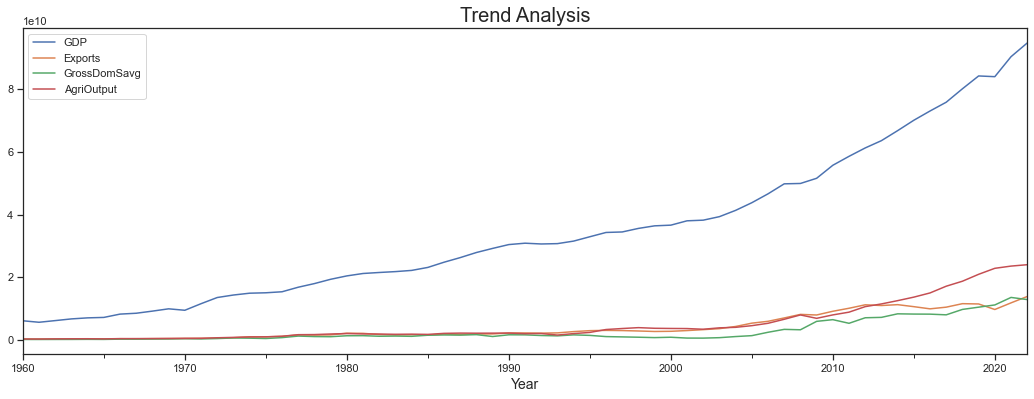

In [76]:
trends.plot(figsize=(18,6))
plt.title('Trend Analysis', fontsize=20)
plt.xlabel('Year', fontsize=14);

In [72]:
trends.corr()

,GDP,Exports,GrossDomSavg,AgriOutput
GDP,1.000000,0.963664,0.925372,0.947725
Exports,0.963664,1.000000,0.935649,0.925276
GrossDomSavg,0.925372,0.935649,1.000000,0.974767
AgriOutput,0.947725,0.925276,0.974767,1.000000


In [73]:
trends_diff = trends.diff(periods=1)

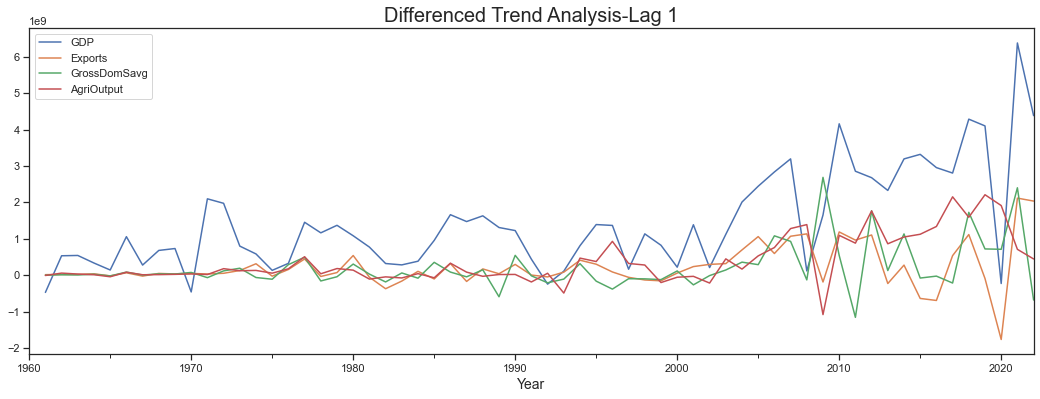

In [77]:
trends_diff.plot(figsize=(18,6))
plt.title('Differenced Trend Analysis-Lag 1', fontsize=20)
plt.xlabel('Year', fontsize=14);

In [78]:
trends_diff.corr()

,GDP,Exports,GrossDomSavg,AgriOutput
GDP,1.000000,0.584186,0.435520,0.551747
Exports,0.584186,1.000000,0.239033,0.185355
GrossDomSavg,0.435520,0.239033,1.000000,0.194159
AgriOutput,0.551747,0.185355,0.194159,1.000000


Focusing predicting our target series (GDP)

In [79]:
#identifying components of out time series (GDP)
data = df['GDP']

Visualizing timeseries data: Plotting line plot to assist get a sense of how our time series dataset changes over time.

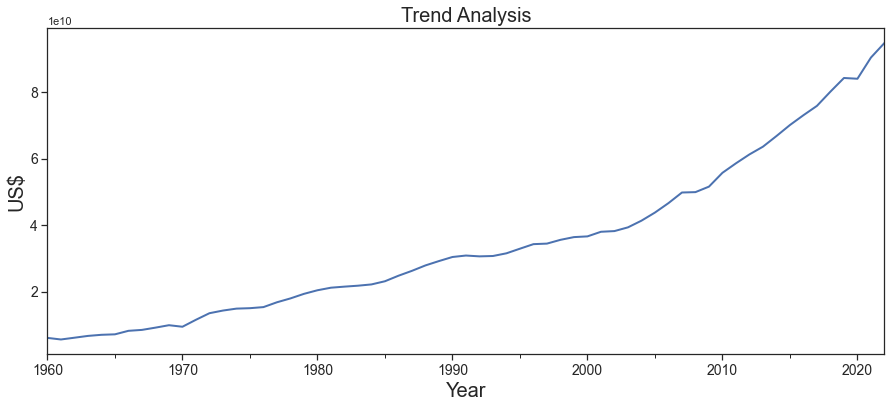

In [39]:
#Line plot to visualize trend
data.plot(figsize = (15,6), linewidth=2, fontsize=14)
plt.ylabel('US$', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.title('Trend Analysis', fontsize=20)
plt.show();

**Time Series Decomposition**: Decompose our time series into 3 distinct components: **`Trend, Seasonality & Residual(Noise)`**; making it easier to quickly identify changing mean or variation our time series.

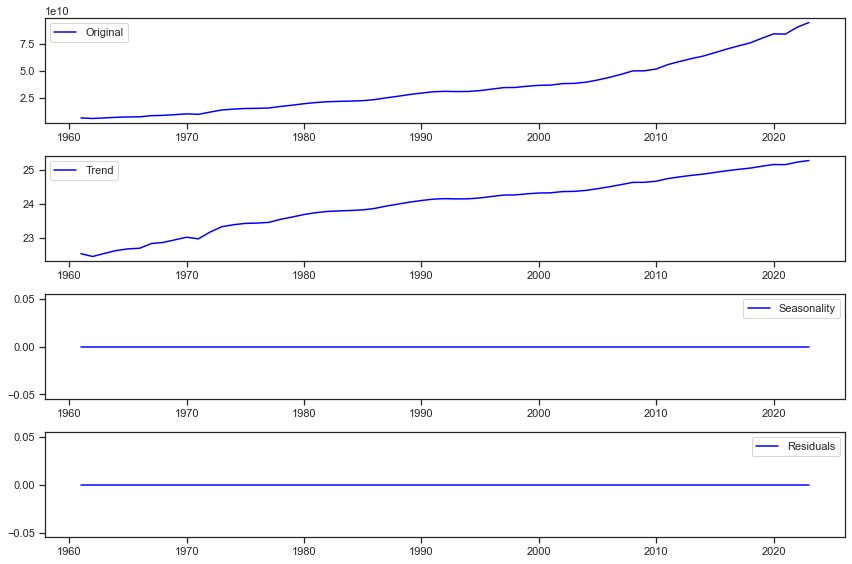

In [60]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(data))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(data, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

> **The plot above clearly shows that GDP is stable, along with no seasonality.**

**Making our Time Series Stationary**

Removing Trends: `The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series in order to get a stationary series`

Below function `stationarity_check()` takes in a time series and performs stationarity checks including rolling statistics and the **Dickey-Fuller test** (Stationarity Test).

In [46]:
def stationarity_check(data):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = data.rolling(window=8, center=False).mean()
    roll_std = data.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(data)
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(data, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize = 20)
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

# HO (Null Hypothesis): Series NOT Stationary
# H1 (Alternate Hypothesis): Series IS Stationary
# pvalue > 0.05 - Fail to Reject H0
# pvalue < 0.05 - Accept H1

Using Function check_stationarity() to see if our series is stationary!

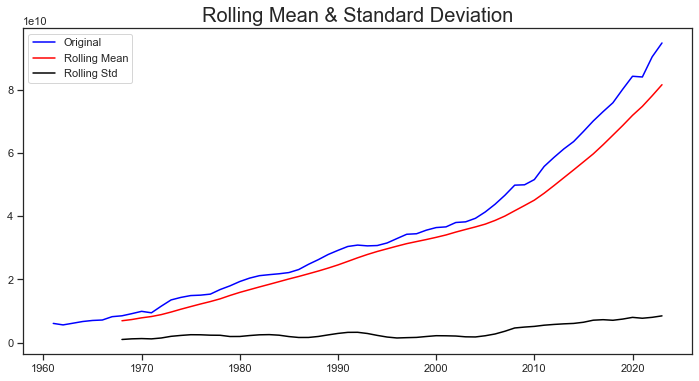

Results of Dickey-Fuller Test: 

Test Statistic                  7.746101
p-value                         1.000000
#Lags Used                      0.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64


In [47]:
stationarity_check(data)

> **Pvalue >0.05 & Test Statistic also greater than critical value (5%); We Fail to Reject Null Hypothesis;\
Time series NOT Stationary**

Performing log and square root transform

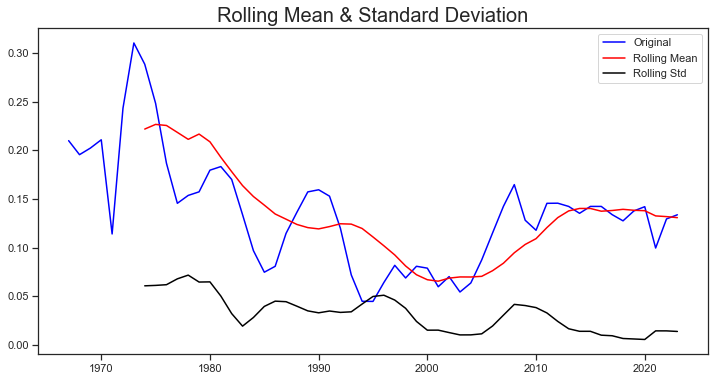

Results of Dickey-Fuller Test: 

Test Statistic                 -2.650680
p-value                         0.082969
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


In [52]:
# log transform
data_log = np.log(data)

# Square root transform
data_sqrt = np.sqrt(data)

# Subtracting rolling mean, with time window of 7
roll_mean = np.log(data).rolling(window=7).mean()

# Subtract the moving average from the log transformed data
data_minus_roll_mean = np.log(data) - roll_mean

# Dropping the missing values from dataset
data_minus_roll_mean.dropna(inplace=True)

# Performing stationarity Check
stationarity_check(data_minus_roll_mean)

> **Pvalue >0.05 & Test Statistic also greater than critical value (5%); We Fail to Reject Null Hypothesis;\
Time Series NOT Stationary**

Subtracting the weighted rolling mean. Repeating all the above steps to calculate the exponential weighted rolling mean with a halflife of 4. Starting from the log-transformed data again & comparing the Dickey-Fuller test results.

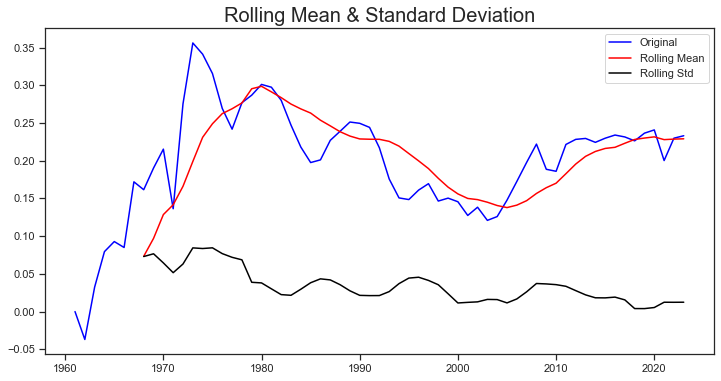

Results of Dickey-Fuller Test: 

Test Statistic                 -2.199323
p-value                         0.206491
#Lags Used                      8.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


In [53]:
# Calculate Weighted Moving Average of log transformed data
exp_roll_mean = np.log(data).ewm(halflife=4).mean()

# Subtract the exponential weighted rolling mean from the original data 
data_minus_exp_roll_mean =  np.log(data) - exp_roll_mean

# Performing stationarity check
stationarity_check(data_minus_exp_roll_mean)

> **Pvalue >0.05 & Test Statistic also greater than critical value (5%); We Fail to Reject Null Hypothesis;\
Time Series NOT Stationary**

Differencing: Using exponentially weighted moving averages, we seem to have removed some trend. Next we shall use differencing to further remove/reduce seasonality/trends. 

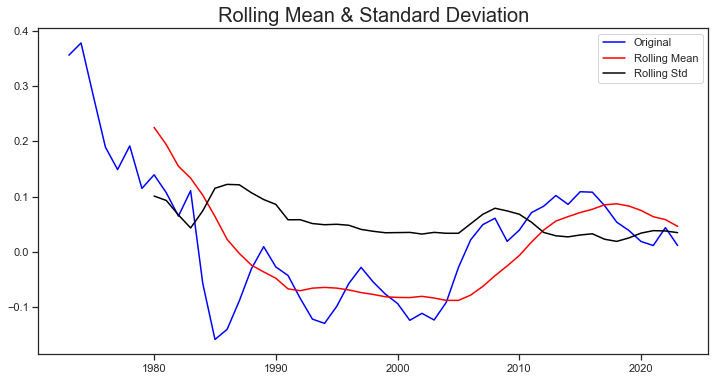

Results of Dickey-Fuller Test: 

Test Statistic                 -3.062476
p-value                         0.029458
#Lags Used                      9.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64


In [54]:
# Difference our data
data_diff = data_minus_exp_roll_mean.diff(periods=12)

# Drop the missing values
data_diff.dropna(inplace=True)

# Performing the stationarity check
stationarity_check(data_diff)

>***Here you can evaluate the test statistic which is smaller than the critical value(5%) and also the p-value is very much less than the significant value 0.05%. Thus rejecting the null hypothesis and considering the data as STATIONARY.***

> **Time Series now ready for Modelling**

**Plotting Auto-Correlation (ACF) & Partial Autocorrelation (PACF) Functions**

Plotting ACF & PACF of differenced time series

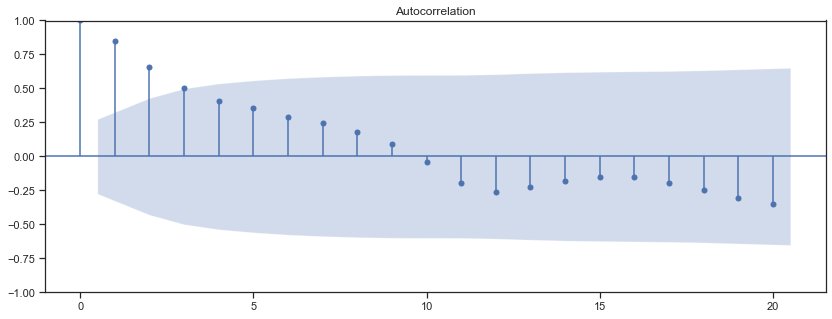

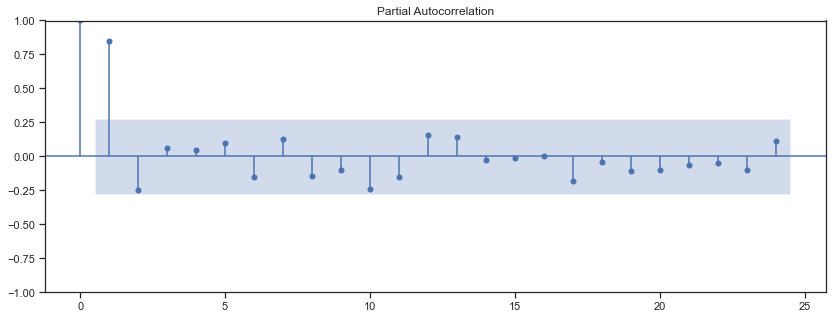

In [81]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_acf(data_diff, lags=20);

plot_pacf(data_diff, lags=24);

Based on the ACF and PACF, we shall proceed to fit an ARMA model with the right orders for AR and MA. We shall try different models and compare AIC and BIC values, as well as significance values for the parameter estimates.

## Modelling, Evaluation & Prediction

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   51
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  85.451
Date:                Wed, 19 Jul 2023   AIC                           -162.903
Time:                        10:19:55   BIC                           -155.175
Sample:                    12-31-1972   HQIC                          -159.950
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0694      0.085      0.821      0.412      -0.096       0.235
ar.L1          0.9145      0.066     13.858      0.000       0.785       1.044
ma.L1          0.3174      0.137      2.313      0.0

<ipython-input-85-12466a6ec42b>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
C:\Users\msagu\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\msagu\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\msagu\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)


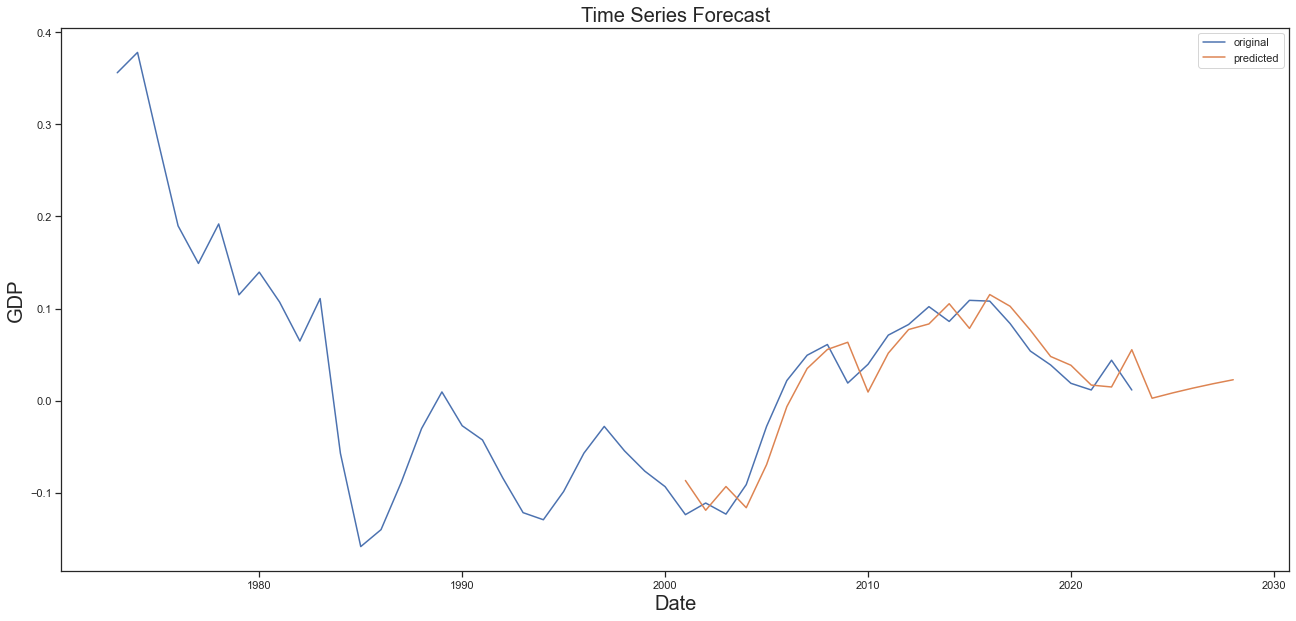

In [85]:
# Impot ARIMA Library from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pandas import datetime

# Instantiate & fit model
model = ARIMA(data_diff, order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit = model.fit()

# Print out summary information on the fit
print(model_fit.summary())

# predict
start_index = datetime(2000, 12, 31)
end_index = datetime(2027, 12, 31)
forecast = model_fit.predict(start=start_index, end=end_index)

# visualization
plt.figure(figsize=(22,10))
plt.plot(data_diff.index,data_diff,label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast",fontsize=20)
plt.xlabel("Date",fontsize=20)
plt.ylabel("GDP",fontsize=20)
plt.legend()
plt.show()

## Findings & Recommendations